# Modelowanie statystyczne

> WSB-NLU, 2023-2024  
> Prowadządza: dr hab. Elżbieta Kubińska

> Autor: Andrzej Kocielski  
> [akocielski@student.wsb-nlu.edu.pl](akocielski@student.wsb-nlu.edu.pl), [and.koc001@gmail.com](and.koc001@gmail.com)
____

## Zaimportowanie potrzebnych modułów

In [1]:
# do manipulacji ścieżkami do katalogów i plików
import os

# do obliczń numerycznych i analizy statystycznej
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels as sm
import pingouin as pg
from sklearn.linear_model import LinearRegression

# do wizualizacji danych
import matplotlib.pyplot as plt
import seaborn as sns

## Załadowanie danych surowych
Dane tygodniowe dla wybranych spółek oraz indeksów w okresie od 01.01.2023 do 15.12.2023. Źródło danych: [stooq.pl](https://stooq.pl/).

In [2]:
# Ścieżka do danych
directory_path = 'dane-finansowe'

# Lista plików csv
csv_files = [file for file in os.listdir(directory_path) if file.endswith('.csv')]

print(f"Lista plików csv:")
for i, file in enumerate(csv_files):
    print(f"{i+1}. {file}") 

Lista plików csv:
1. comarch_w.csv
2. kghm_w.csv
3. eurpln_w.csv
4. spx_w.csv
5. echo_w.csv
6. xaupln_w.csv
7. apator_w.csv
8. wig_w.csv


### Przygotowanie danych roboczych

In [3]:
# Inicjalizaja pustego DataFrame
merged_df = pd.DataFrame()

# Zaczytanie danych z poszczególnych plików csv i dodanie do wspólnego DataFrame
for file in csv_files:
    file_path = os.path.join(directory_path, file)
    df = pd.read_csv(file_path)

    # Dodanie nazwy poliku do nazwy kolumny (poza pierwszą, czyli datą)
    nazwa_pliku = os.path.splitext(os.path.basename(file))[0][:-2].upper()
    df.columns = [df.columns[0]] + [f"{col}_{nazwa_pliku}" for col in df.columns[1:]]
    
    # Łączenie danych z poszczególnych plików 
    merged_df = pd.concat([merged_df, df], ignore_index=False, axis=1)

# Usunięcie powtórzonych kolumn z datami
merged_df = merged_df.T.drop_duplicates().T


In [4]:
# Zmiana typu danych 
cols = list(merged_df.columns)
cols.remove('Data')
for col in cols:
    merged_df[col] = merged_df[col].astype(float)

merged_df['Data'] = pd.to_datetime(merged_df['Data'])

# ustawienie daty jako indeksu
merged_df.set_index('Data', inplace=True)

In [ ]:
print(f"Liczba obserwacji (wierszy): {merged_df.shape[0]}, liczba kolumn: {merged_df.shape[1]}")

In [ ]:
print(f"Podgląd kilku pierwszych wierszy:")
merged_df.head()

In [ ]:
# sprawdzamy brakujące dane (ich liczbę) w poszczególnych kolumnach 
merged_df.isnull().sum() 

___
## Interpretacja graficzna danych

In [58]:
# ogólne ustawienie stylu wykresów
# print(plt.style.available)
plt.style.use('classic')
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 10
plt.rcParams['lines.linewidth'] = 0.75
plt.rcParams['lines.markersize'] = 1.2

### Szereg czasowy zamknięcia tygodnia

In [6]:
# przygotowanie podzbioru
zamkniecia = ['Zamkniecie_COMARCH', 'Zamkniecie_KGHM', 'Zamkniecie_EURPLN', 'Zamkniecie_SPX', 'Zamkniecie_ECHO', 'Zamkniecie_XAUPLN', 'Zamkniecie_APATOR', 'Zamkniecie_WIG']
zamkniecia_df = merged_df[zamkniecia]

spolki = ['Zamkniecie_COMARCH', 'Zamkniecie_KGHM', 'Zamkniecie_ECHO', 'Zamkniecie_APATOR']
spolki_df = merged_df[spolki]

### Zmienność wartości spółek w badanym okresie

In [ ]:
# wartość indeksu WIG w badanym okrecie
walor = zamkniecia_df.columns[-1] 

# dane
plt.plot(zamkniecia_df[walor]) 

plt.title(f'{walor}')
plt.xlabel('Czas')
plt.ylabel('Wartość indeksu')
plt.grid(True, linestyle='dotted')

plt.show()

In [ ]:
# wartość danego waloru w badanym okrecie
for walor in range(len(spolki_df.columns)):
    plt.plot(zamkniecia_df[spolki_df.columns[walor]], label=spolki_df.columns[walor]) 

plt.title(f'Zamkniecia wybranych spółek')
plt.xlabel('Czas')
plt.ylabel('Cena zamknięcia (PLN)')
plt.grid(True,linestyle='dotted') 
plt.legend(fontsize='10', loc='upper center')

plt.show()

In [ ]:
# porównanie wybranych spółek do indeksu WIG

# parametry pierwszego wykresu (lewa oś y)
fig, ax1 = plt.subplots()

# wizualizacja wybranych spółek w badanym okrecie (lewa oś y)
for walor in range(len(spolki_df.columns)):
    ax1.plot(zamkniecia_df[spolki_df.columns[walor]], linestyle='-', label=spolki_df.columns[walor][11:]) 
ax1.set_xlabel('Czas')
ax1.set_ylabel('Cena zamknięcia spółek (PLN)', color='grey')
ax1.tick_params('y', colors='grey')

# parametry drugiego wykresu (prawa oś y; ta sama oś x)
ax2 = ax1.twinx()

# wizualizacja ineksu WIG w badanym okrecie (prawa oś y)
wig = zamkniecia_df.columns[-1]
ax2.plot(zamkniecia_df[wig], color='black', linestyle='--', label=f'{wig[11:]} (prawa oś)')
ax2.set_ylabel('Punkty indeksu WIG', color='black')
ax2.tick_params('y', colors='black')

# kreślenie wykresów
plt.title(f'Porównanie wybranych spółek do indeksu WIG')
lines, labels = ax1.get_legend_handles_labels()
lines_wig, labels_wig = ax2.get_legend_handles_labels()
ax2.legend(lines + lines_wig, labels + labels_wig, fontsize='10', loc='upper center')
plt.grid(True, linestyle='dotted') 
plt.show()

### Graficzna prezentacja zamienności tygodniowych zamknięć wskaźników

In [ ]:
# Porównanie zmienności indeksu SP500 i inteksu WIG w badanym okresie

# parametry pierwszego wykresu (lewa oś y)
fig, ax1 = plt.subplots()

# wizualizacja danych na lewej osi y
# plt.plot(merged_df['Zamkniecie_SPX'], color='b', linestyle='-', label=f'{S&P500[11:]} (lewa oś)') 
sp500 = zamkniecia_df.columns[3]
ax1.plot(zamkniecia_df[sp500], color='b', linestyle='-', label=f'{sp500[11:]} (lewa oś)')

ax1.set_xlabel('Czas')
ax1.set_ylabel('Punkty indeksu S&P500', color='b')
ax1.tick_params('y', colors='b')

# parametry wykresu dl prawej osi y (ta sama oś x)
ax2 = ax1.twinx()

# wizualizacja ineksu WIG w badanym okrecie (prawa oś y)
wig = zamkniecia_df.columns[-1]
ax2.plot(zamkniecia_df[wig], color='r', linestyle='-', label=f'{wig[11:]} (prawa oś)')
ax2.set_ylabel('Punkty indeksu WIG', color='r')
ax2.tick_params('y', colors='r')

# kreślenie wykresów
plt.title(f'Porównanie wybranych wskaźników do indeksu WIG')
lines, labels = ax1.get_legend_handles_labels()
lines_wig, labels_wig = ax2.get_legend_handles_labels()
ax2.legend(lines + lines_wig, labels + labels_wig, fontsize='10', loc='upper center')
plt.grid(True, linestyle='dotted') 
plt.show()

In [ ]:
# Porównanie zmienności cen EUR oraz cen złota w badanym okresie

# parametry pierwszego wykresu (lewa oś y)
fig, ax1 = plt.subplots()

# wizualizacja danych na lewej osi y
# plt.plot(merged_df['Zamkniecie_SPX'], color='b', linestyle='-', label=f'{S&P500[11:]} (lewa oś)') 
eur = zamkniecia_df.columns[2]
ax1.plot(zamkniecia_df[eur], color='b', linestyle='-', label=f'{eur[11:]} (lewa oś)')

ax1.set_xlabel('Czas')
ax1.set_ylabel('Cena 1 EUR [PLN]', color='b')
ax1.tick_params('y', colors='b')

# parametry wykresu dl prawej osi y (ta sama oś x)
ax2 = ax1.twinx()

# wizualizacja ineksu WIG w badanym okrecie (prawa oś y)
zloto = zamkniecia_df.columns[5]
ax2.plot(zamkniecia_df[zloto], color='g', linestyle='-', label=f'{zloto[11:]} (prawa oś)')
ax2.set_ylabel('Cena 1 uncji złota [PLN]', color='g')
ax2.tick_params('y', colors='g')

# kreślenie wykresów
plt.title(f'Porównanie cen EUR oraz złota')
lines, labels = ax1.get_legend_handles_labels()
lines_wig, labels_wig = ax2.get_legend_handles_labels()
ax2.legend(lines + lines_wig, labels + labels_wig, fontsize='10', loc='upper center')
plt.grid(True, linestyle='dotted') 
plt.show()

___
## Statystyka opisowa
### Dla spółki Comarch (jako przykład)

In [ ]:
comarch_cols = ["Zamkniecie_COMARCH", "Wolumen_COMARCH"]

### Wybrane miary zmienności
- Rozstęp
- Odchylenie ćwiartkowe
- Wariancja
- Odchylenie standardowe
- Współczynnik zmienności

### Wybrane miary pozycyjne
- Średnia
- Kwantyle
- Mediana (kwantyl 50%)
- Moda

### Wybrane miary kształtu
- Skośność
- Kurtoza

In [7]:
# Przygotowanie parametrów statystycznych

# własna funkcja do obliczania inter quartile range (IQR)
def q25(column):
    return column.quantile(0.25)
def q75(column):
    return column.quantile(0.75)    
def IQR(column): 
    q25, q75 = column.quantile([0.25, 0.75])
    return q75-q25

# własna funkcja do obliczania zakresu
def range_max_min(column):
    return column.max() - column.min()

# własna funkcja do obliczania współczynnika zmienności (coefficient of variance)
def cv(column):
    return stats.variation(list(column)) * 100

# własna funkcja do wyznaczania błędu standardowego
def sem(column):
    return stats.sem(list(column))

# własna funkcja do wyznaczenia przedziału ufności dla średniej
def ci(column):
    conf_level = 0.95
    df = len(column) - 1
    sem = stats.sem(list(column))
    # return stats.t.interval(conf_level, df, np.mean(column), sem)

    lower, upper = stats.t.interval(conf_level, df, np.mean(column), sem)
    lower = round(lower, 3)
    upper = round(upper, 3)
    return lower, upper

charakterystyka = ["min", q25, "mean", "median", q75, IQR, "max", range_max_min, "var", "std", cv, sem, ci, "skew", "kurtosis"]

In [ ]:
merged_df[comarch_cols].agg(charakterystyka)

### Interpretacja wybranych statystyk dla _cen zamknięcia_ akcji Comarch w interwałach tygodniowych

$min$ -> najniższa cena akcji Comarch na zamknięciu tygodniowym w obserwowanym okresie

$max$ -> najwyższa cena akcji na zamknięciu tygodniowym 

$mean$ -> średnia arytmetyczna cen zamknięcia

$median$ -> mediana (wartość środkowa); wartość mniejsza od średniej wskazuje na skośność statystyki

$std$ -> odchylenie standardowe wyrażone w PLN; stosunkowo duża wartość $std$ w stosunku do średniej wskazuje na znaczny rozrzut zmiennej 

$cv$ -> współczynnik zmienności; średnia / odchylenie standardowe

$sem$ -> błąd standardowy średniej; rozrzut estymatorów z próby wokół parametru populacji, czyli jak bardzo średnia próbki jest "rozmyta" (miara niepewności testu)

$ci$ -> przedział ufności; z prawdopodobieństwem 0.95 prawdziwa wartość parametru populacyjnego (średnia cen zamknięcia) znajduje się w tym przedziale

$skew$ -> skośność; wartość większa od 1 świadczy o skośności lewostronnej

$kurtosis$ -> kurtoza; bada czy rozkład jest płaski, czy stromy; kurtoza < 0 wskazuje na rozkład platykurtyczny, czyli rozkład niski i szeroki (Wartości zmiennej są bardziej rozrzucone wokół średniej oraz mamy mniejsze prawdopodobieństwo wystąpienia wartości ekstremalnych)


___
## Analiza kursu EUR - PLN
### Najważniejsze parametry statystyczne

In [8]:
parametry_eurpln = merged_df["Zamkniecie_EURPLN"].agg(charakterystyka)

In [9]:
min_eurpln = parametry_eurpln.iloc[0]
mean_eurpln = parametry_eurpln.iloc[2]
max_eurpln = parametry_eurpln.iloc[6]
std_eurpln = parametry_eurpln.iloc[9]
skew_eurpln = parametry_eurpln.iloc[13]
kurt_eurpln = parametry_eurpln.iloc[14]

### Histogram

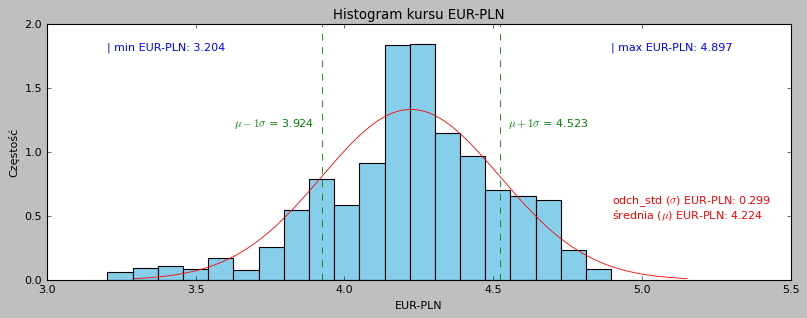

In [20]:
# Utwórzenie histogram
plt.hist(merged_df["Zamkniecie_EURPLN"], bins=20, density=True, color='skyblue')

# Wykreślenie krzywej gęstości prawdopodobieństwa (pdf)
# xmin, xmax = plt.xlim()
# x_zakres = np.linspace(xmin, xmax, 1000)
x_zakres = np.linspace(mean_eurpln - 3.1 * std_eurpln, mean_eurpln + 3.1 * std_eurpln, 1000)
plt.plot(x_zakres, stats.norm.pdf(x_zakres, mean_eurpln, std_eurpln), 'r')

# oznaczenie zakresu -odch-std oraz +odch_std
plt.axvline(mean_eurpln-std_eurpln, color='g', linestyle='--')
plt.axvline(mean_eurpln+std_eurpln, color='g', linestyle='--')

# Opis wykresu i osi
plt.title('Histogram kursu EUR-PLN')
plt.xlabel('EUR-PLN')
plt.ylabel('Częstość')
plt.text(min_eurpln, 1.8, f'| min EUR-PLN: {min_eurpln:.3f}', color='b')
plt.text(max_eurpln, 1.8, f'| max EUR-PLN: {max_eurpln:.3f}', color='b')
plt.text(4.9, 0.48, f'średnia ($\mu$) EUR-PLN: {mean_eurpln:.3f}', color='r')
plt.text(4.9, 0.60, f'odch_std ($\sigma$) EUR-PLN: {std_eurpln:.3f}', color='r')
plt.text(3.63, 1.2, f'$\mu-1 \sigma$ = {mean_eurpln-std_eurpln:.3f}', color='g')
plt.text(4.55, 1.2, f'$\mu+1 \sigma$ = {mean_eurpln+std_eurpln:.3f}', color='g')

# Kreślenie
plt.show()

Rozkład z grubsza przypomina normalny, choć nie-symetryczny i ściśnięty blisko wartości oczekiwanej. Porównajmy zatem niektóre parametry rozkładu.

In [ ]:
print(f'skew \t   {stats.skew(merged_df["Zamkniecie_EURPLN"]):.6f}')
print(f'kurtosis    {stats.kurtosis(merged_df["Zamkniecie_EURPLN"]):.6f}')

Zatem wnioskujemy, iż:  
a) rozkład jest jednak względnie symetryczny, ponieważ skośność w zakresie <-1,1>  
b) leptokurtyczny (tj. ściśnięty), ponieważ kurtoza > 0

### Wyznaczenie trzech sigm dla cen zamknięcia EUR-PLN

In [37]:
# Wartości Z-score dla trzech odchyleń standardowych
zakres_sigm = [-3, -2, -1, 1, 2, 3]

print(f'Wartość oczekiwana (średnia): {mean_eurpln:.4f}')
print(f'Odchylenie standardowe: {std_eurpln:.4f}')

# Oblicz dystrybuantę dla odchyleń standardowych (wartość Z-score)
sigmy = [s * std_eurpln + mean_eurpln for s in zakres_sigm]
for s in sigmy:
    cumulative_probability = stats.norm.cdf(s, loc=mean_eurpln, scale=std_eurpln)
    print(f'Dystrybuanta dla {(s-mean_eurpln)/std_eurpln:.0f} sigma ({s:.4f} PLN): {cumulative_probability:.4f}')

Wartość oczekiwana (średnia): 4.2236
Odchylenie standardowe: 0.2994
Dystrybuanta dla -3 sigma (3.3254 PLN): 0.0013
Dystrybuanta dla -2 sigma (3.6248 PLN): 0.0228
Dystrybuanta dla -1 sigma (3.9242 PLN): 0.1587
Dystrybuanta dla 1 sigma (4.5230 PLN): 0.8413
Dystrybuanta dla 2 sigma (4.8224 PLN): 0.9772
Dystrybuanta dla 3 sigma (5.1218 PLN): 0.9987


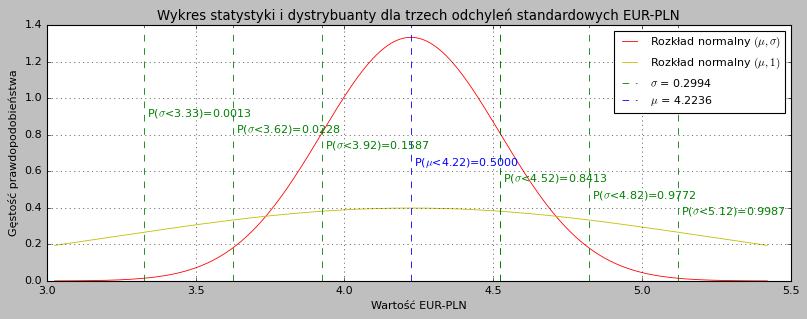

In [73]:
# Analiza graficzna trzech sigm

# Tworzenie danych dla osi X (wartości Z-score)
x_zakres = np.linspace(mean_eurpln - 4 * std_eurpln, mean_eurpln + 4 * std_eurpln, 1000)

# Tworzenie wykresu statystyki
plt.plot(x_zakres, stats.norm.pdf(x_zakres, mean_eurpln, std_eurpln), 'r', label=f'Rozkład normalny $(\mu, \sigma)$')
plt.plot(x_zakres, stats.norm.pdf(x_zakres, loc=mean_eurpln, scale=1), color='y', label=f'Rozkład normalny $(\mu, 1)$')
plt.axvline(mean_eurpln + std_eurpln, color='g', linestyle='--', label=f'$\sigma$ = {std_eurpln:.4f}')

# wartość oczekiwana
plt.axvline(mean_eurpln, color='b', linestyle='--', label=f'$\mu$ = {mean_eurpln:.4f}')

# Dodanie dystrybuant dla różnych odchyleń standardowych
for s in sigmy:
    plt.axvline(s, color='g', linestyle='--')#, label=f'{(s-mean_eurpln)/std_eurpln:.0f}$\sigma$ = {s:.4f}')

    # Obliczanie dystrybuanty dla danej sigmy
    cumulative_probability = stats.norm.cdf(s, loc=mean_eurpln, scale=std_eurpln)
    plt.text(.01+s, 1.9+s*-.3, f'P($\sigma$<{s:.2f})={cumulative_probability:.4f}', color='g')

plt.text(mean_eurpln+.01, 0.63, f'P($\mu$<{mean_eurpln:.2f})={stats.norm.cdf(mean_eurpln, loc=mean_eurpln, scale=std_eurpln):.4f}', color='b')

# Konfiguracja wykresu
plt.title('Wykres statystyki i dystrybuanty dla trzech odchyleń standardowych EUR-PLN')
plt.xlabel('Wartość EUR-PLN')
plt.ylabel('Gęstość prawdopodobieństwa')
plt.legend(fontsize='10')
plt.grid(True)
plt.show()

___
## Testy statystyczne
### Czy częstość występowania cen EUR-PLN ma rozkład normalny

In [74]:
# Test Kołmogorowa-Smirnowa
statistic, p_value = stats.kstest(merged_df['Zamkniecie_EURPLN'], 'norm')
print("Statystyka testowa:", statistic)
print("Wartość p:", p_value)

# Interpretacja wyników
alpha = 0.05
if p_value > alpha:
    print("Wniosek: nie ma podstaw do odrzucenia hipotezy zerowej (o normalności rozkładu).")
else:
    print("Wniosek: odrzucono hipotezę zerową na korzyść hipotezy alternatywnej (nie normalny rozklad).")

Statystyka testowa: 0.9993218667162591
Wartość p: 0.0
Wniosek: odrzucono hipotezę zerową na korzyść hipotezy alternatywnej (nie normalny rozklad).


In [75]:
# Test D'Agostino i Pearson:
statistic, p_value = stats.normaltest(merged_df['Zamkniecie_EURPLN'])

print("Statystyka testowa:", statistic)
print("Wartość p:", p_value)

# Interpretacja wyników
alpha = 0.05
if p_value > alpha:
    print("Wniosek: nie ma podstaw do odrzucenia hipotezy zerowej (rozklad normalny).")
else:
    print("Wniosek: odrzucono hipotezę zerową na korzyść hipotezy alternatywnej (nie normalny rozklad).")

Statystyka testowa: 60.17132120784457
Wartość p: 8.589415573446294e-14
Wniosek: odrzucono hipotezę zerową na korzyść hipotezy alternatywnej (nie normalny rozklad).


___
## Analiza portfelowa
Na przykładzie cen zamknięcia spółki Comarch wobec indeksu WIG

### Wyznaczenie korelacji

In [76]:
# Dane (zmienne niezależne i zależna)
x = merged_df['Zamkniecie_WIG']
y = merged_df['Zamkniecie_COMARCH']

# Obliczenie współczynnika korelacji (Pearson)
correlation_coefficient = np.corrcoef(x, y)[0, 1]
# Wyświetlenie współczynnika korelacji
print(f'Współczynnik korelacji: {correlation_coefficient:.2f}')

Współczynnik korelacji: 0.80


### Model regresji liniowej

Współczynnik nachylenia (a): [0.73127588]
Wyraz wolny (b): [0.00144535]
Współczynnik determinacji (R^2): 0.1844239019603393


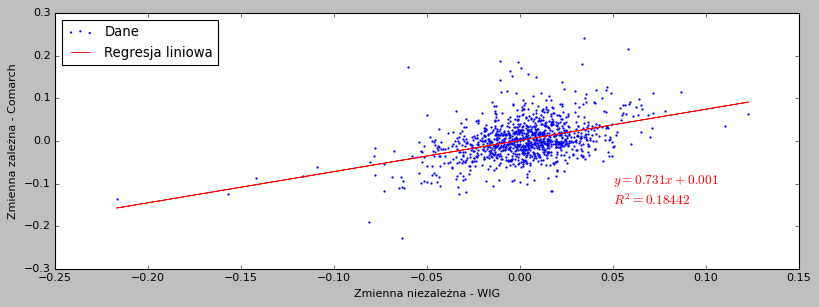

In [77]:
# Przekształcenie elementów serii, tak aby uzyskać procentową zmianę między elementami, tj. (bierzący/poprzedni - 1) 
x = merged_df['Zamkniecie_WIG'].pct_change().dropna()
y = merged_df['Zamkniecie_COMARCH'].pct_change().dropna()  

# Przekształcenie danych do postaci wymaganej przez scikit-learn
X = x.values.reshape(-1, 1)
y = y.values.reshape(-1, 1)

# Inicjalizacja modelu regresji liniowej
model = LinearRegression()

# Dopasowanie modelu do danych
model.fit(X, y)

# Wyświetlenie wyników regresji
print("Współczynnik nachylenia (a):", model.coef_[0])
print("Wyraz wolny (b):", model.intercept_)
print("Współczynnik determinacji (R^2):", model.score(X, y))

# Dodanie równania regresji liniowej na wykresie
equation = f'$y = {float(model.coef_[0]):.3f}x + {float(model.intercept_):.3f}$'
plt.annotate(equation, xy=(0.05, -.1), fontsize=12, color='red')
r = f'$R^2 = {model.score(X, y):.5f}$'
plt.annotate(r, xy=(0.05, -.15), fontsize=12, color='red')

# Wykres danych i regresji
plt.scatter(x, y, color='blue', label='Dane', s=1)
plt.plot(x.values.reshape(-1, 1), model.predict(X), color='red', label='Regresja liniowa')
plt.xlabel('Zmienna niezależna - WIG')
plt.ylabel('Zmienna zależna - Comarch')
plt.legend(loc='upper left')
plt.show()

Interpretacja:
- Ponieważ współczynnik kierunkowy jest różny od zera (w stopniu 'na oko' wystarczająco istotnym - do sprawdzenia), oraz dodatni, istnieje dodatnia korelacja między cenami spółki Comarch i wartościami indeksu WIG.
- Wyraz wolny jest bardzo bliski zeru (do sprawdzenia czy istotnie bliski), zatem zachowanie cen spółki Comarch sugeruje bliskie odwzorowanie zachowania indeksu WIG (ani systematycznie nie bije rynku, ani systematycznie nie przegrywa z rynkiem).

___
### Model wielowymiarowy regresji liniowej  

Model wielowymiarowej regresji liniowej uwzględnia więcej niż jedną zmienną niezależną (cechę).  

W poniższym modelu wielowymiarowej regresji zastosujemy metodę krokową wsteczną.

Zmienną zależną będzie zamknięcia spółki **Comarch**, oraz następujące zmienne niezależne:
- zamknięcia spółki KGHM
- zamknięcia spółki Echo
- zamknięcia spółki Apator
- indeks WIG
- indeks S&P500
- kurs EUR-PLN
- kurs złota 

___
## Dodatkowe źródła
- [https://mateuszgrzyb.pl/3-metody-analizy-normalnosci-rozkladu-w-python/](https://mateuszgrzyb.pl/3-metody-analizy-normalnosci-rozkladu-w-python/)
- [https://github.com/bilalonur/financial-visualization/blob/main/finance-visualization.ipynb](https://github.com/bilalonur/financial-visualization/blob/main/finance-visualization.ipynb)
- [https://python.cogsci.nl/numerical/statistics/](https://python.cogsci.nl/numerical/statistics/)
- [https://pingouin-stats.org/](https://pingouin-stats.org/)
- [https://www.naukowiec.org/wiedza/statystyka/](https://www.naukowiec.org/wiedza/statystyka/)

___
Andrzej Kocielski, 2024